---
title: Clustering
---

## Introduction

In this section, I will be using various clustering algorithms to cluster data from the National Survey on Drug Use and Health (NSDUH) performed by the Substance Abuse and Mental Health Services Administration (SAMHSA) in 2021. This survey is conducted each year and provides information on drug usage and mental health on tens of thousands of Americans, giving insights into the annual trends in the usage of illicit substances and the state of mental health. 

Throughout this project, my goal has been to identify a link between the usage of cannabis and psychosis. With these clustering algorithms, I hope to identify a link between the usage of cannabis and mental health outcomes. While the data includes very detailed information on drug usage, mental illness information is limited due to the sensitive nature of the data. We will use the variable `smipppy`, (Probability of Serious Mental Illness in Past Year) as a proxy for psychosis. We will assess how well the clusters based on drug usage data align with the variable `smipppy` to continue working to identify a link between cannabis usage and psychosis.

## Theory

Before we begin implementing the clustering algorithms, we will briefly discuss the theory underlying each algorithm. We will use three different approaches for clustering: k-means clustering, DBSCAN, and hierarchical clustering.

### K-Means Clustering

K-means clustering is a partitional clustering algorithm that aims to partition, or divide, the data into `k` clusters. In k-means clustering, `k` is a hyperparameter that should be tuned to determine the optimal number of clusters for a given dataset.

In k-means, the center of each cluster is referred to as the "centroid". For each of the `k` clusters, a centroid is computed by finding the center of all the points in the cluster. The centroid can be computed using the mean, median, mode, or another measure of centrality. Often, the initial centroids are chosen at random (though there are more principled ways to choose the initial centroids). Each observation in the data is assigned to a cluster based on whichever centroid it is closest to. The distance metric is a hyperparameter that can be selected by the user. Once the observations have been assigned to clusters, the centroids are then updated by averaging the observations in the cluster. This process is repeated until the clusters become stable or until a maximum number of iterations has been reached.

It is noteable that k-means clustering can result in different clusters each time it is run, depending on the separability of the data and the starting position of the centroids. Like most machine learning models, it involves an element of randomness that makes the results slightly different each time.

### DBSCAN

Density-based spatial clustering of applications with noise, more commonly known as DBSCAN, is a non-parametric clustering algorithm. Similar to k-means, it is a partitional algorithm that divides the data into a given number of clusters. DBSCAN groups points together based on density, grouping together points that a highly packed together.

DBSCAN works by identifying areas of high density, where points are closely packed together as clusters. Points within a certain distance of the cluster will be included in the cluster. The points in the same neighborhood, meaning the points that are within a certain small distance from each other, are grouped into clusters. This given small distance is known as `epsilon`, or $\epsilon$. When tuning DBSCAN, one must choose an `epsilon` value rather than the number of clusters. The value for `epsilon` indirectly dictates the number of resulting clusters.

The main advantage of DBSCAN is its ability to find non-linear patterns. DBSCAN is adept at identifying clusters that are not linearly separable, an advantage over k-means clustering. It is also more robust to noise than k-means because it does not rely on the mean as a measure of center (which is inherently affected by outliers). DBSCAN is also not impacted by the choice of any initial centroids, meaning its results are more consistent than k-means clustering.

Source: [https://en.wikipedia.org/wiki/DBSCAN](https://en.wikipedia.org/wiki/DBSCAN)

### Hierarchical Clustering

Hierarchical clustering aims to organize the values into nested clusters, like a tree, where each observation can be in more than one cluster. The goal of hierarchical clustering is to define nested clusters from the data, grouping the data into successive groups that may be overlapping. Like partitional clustering, can still use decide the optimal number of clusters using the `n_clusters` hyperparameter.

For our implementation of hierarchical clustering, we will be using the agglomerative clustering algorithm in `scikit-learn`. There are two types of hierarchical clustering: divise and agglomerative. Divise clustering works by recursive splitting the data into smaller groups, starting from the whole data set. Agglomerative clustering is a bottom up method that functions by assuming that each observation is in its own cluster. As the algorithm moves up the hierarchy, clusters are merged until the root of the tree forms one final cluster containing all the data. These two hierarchical clustering approaches will leads to different outcomes because of the different algorithmic mechanisms.

### Model Selection

In order to determine the optimal hyperparameters for each model, we will rely on the silhouette score. Silhouette score is a measure of how similar a point is to its own cluster compared to other clusters. It ranges from -1 to 1, where -1 indicates that the clustering is very poor and 1 represents perfectly separated clusters.

Throughout these modeling attempts, my goal with be to select the hyperparameters that maximize the silhouette score, resulting in the clusters with the highest separability. Since each point gets its own silhouette score, we will take the average of all the silhouette scores for all the observations based on a given clustering model. To compare the clustering methods to each other, we will determine which method produces the highest average silhouette score.

I will also use the elbow method to determine the optimal hyperparameters. Often the highest separability and highest silhouette score occurs with a very high number of clusters. We can plot the number of clusters versus the silhouette score to find the "elbow" of the graph. This identifies where more clusters leads to diminishing returns, identifying the optimal number of clusters for the data. I will also use inertia as a metric for optimizing the number of clusters if the silhouette score is does not provide a clear elbow. Inertia is the sum of the squared distances between each point and the cluster center. Plotting interia versus the number of clusters is another helpful way to identify the optimal number of clusters, choosing the number of clusters that minimizes inertia and the number of clusters. The elbow will be the point where the inertia begins to decrease at a slower rate, showing that it is leveling off.

## Methods

Now that we have a strong theoretical understanding of each of these clustering algorithms, let's apply them to our data in order to explore the link between cannabis usage and psychosis (using our proxy, `smipppy`).

#### Data Selection

We will remove the target variable, `smipppy`, from the dataset. We will use it again at the end to assess the performance of our clustering algorithms.

In [12]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
nsduh = pd.read_csv('../../data/clean_data/nsduh_2021.csv')

/var/folders/4w/gxhbpkhj19j6ydpft6pz0grc0000gn/T/ipykernel_16402/3212366654.py:8: DtypeWarning: Columns (5,11,57,58,60,501,513,514,515,516,517,519,520,521,522,523,541,546,550,551,552,553,563,569,570,571,856,857,858,859,860,861,862,863,864,865,866,867,868,1056,1057,1058,1061,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1081,1082,1083,1084,1085,1086,1087,1088,1089,1090,1094,1095,1096,1097,1098,1099,1100,1101,1102,1103,1104,1105,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115,1116,1117,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149,1150,1151,1152,1153,1169,1170,1171,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225,1250,1251,1252,

#### Feature Selection

We will only the data that directly relates to cannabis usage for our clustering algorithms, shown in the code below. This will allow us to cluster the participants based on cannabis usage and determine if there is any connection between cannabis usage and probability of severe mental illness. 

In [38]:
# Select all the variables that are related to marijuana
nsduh_mj = nsduh[['mjage', 'mjmfu', 'mjyrtot', 'mrbstway', 'mrdaypyr', 'mrdaypwk', 'MR30EST']]
nsduh_mj = nsduh_mj.dropna()

In [77]:
nsduh_mj.columns

Index(['mjage', 'mjmfu', 'mjyrtot', 'mrbstway', 'mrdaypyr', 'mrdaypwk',
       'MR30EST'],
      dtype='object')

We turn "Never Used" into a numeric value so that the columns are numeric rather than categorical.

In [87]:
# change "Never Used" to -1 so that the data is numeric for clustering
nsduh_mj['mjage'] = nsduh_mj['mjage'].replace('Never Used', -1)
nsduh_mj['mjmfu'] = nsduh_mj['mjmfu'].replace('Never Used', -1)
nsduh_mj['mjyrtot'] = nsduh_mj['mjyrtot'].replace('Never Used', -1)
nsduh_mj['mrbstway'] = nsduh_mj['mrbstway'].replace('Never Used', -1)
nsduh_mj['mrdaypyr'] = nsduh_mj['mrdaypyr'].replace('Never Used', -1)
nsduh_mj['mrdaypwk'] = nsduh_mj['mrdaypwk'].replace('Never Used', -1)
nsduh_mj['MR30EST'] = nsduh_mj['MR30EST'].replace('Never Used', -1)

### K-Means Clustering

We'll begin with k-means clustering, using the elbow method to determine the optimal number of clusters.

In [89]:
# silence warnings
import warnings
warnings.filterwarnings('ignore')

# K means clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from tqdm import tqdm

# Standardize the data
scaler = StandardScaler()
scaled_nsduh_mj = scaler.fit_transform(nsduh_mj)

# Fit the model
kmeans_data = {}
for i in tqdm(range(2, 11)):
    kmeans = KMeans(n_clusters=i, random_state=812, n_init=10, max_iter=300, init='k-means++')
    kmeans.fit(scaled_nsduh_mj)
    kmeans_data[i] = kmeans.inertia_, silhouette_score(scaled_nsduh_mj, kmeans.labels_)

100%|██████████| 9/9 [06:33<00:00, 43.77s/it]


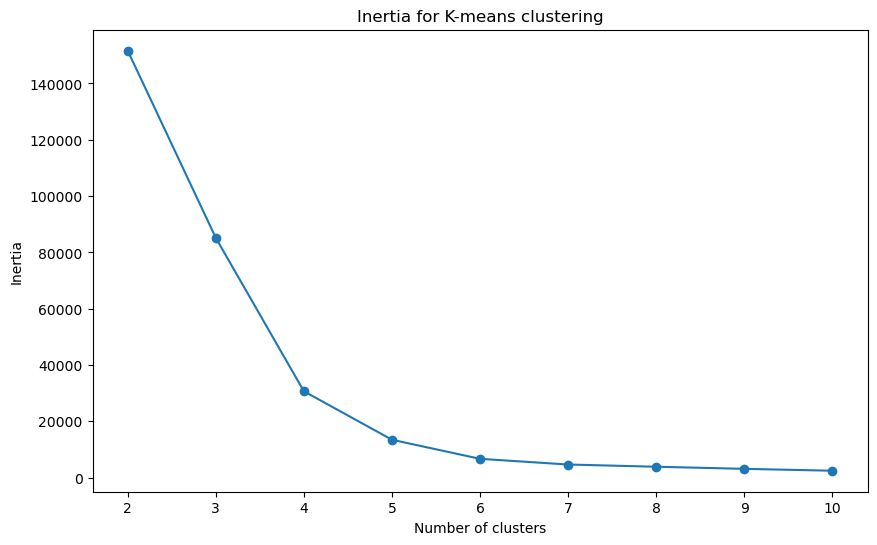

Text(0.5, 1.0, 'Silhouette score for K-means clustering')

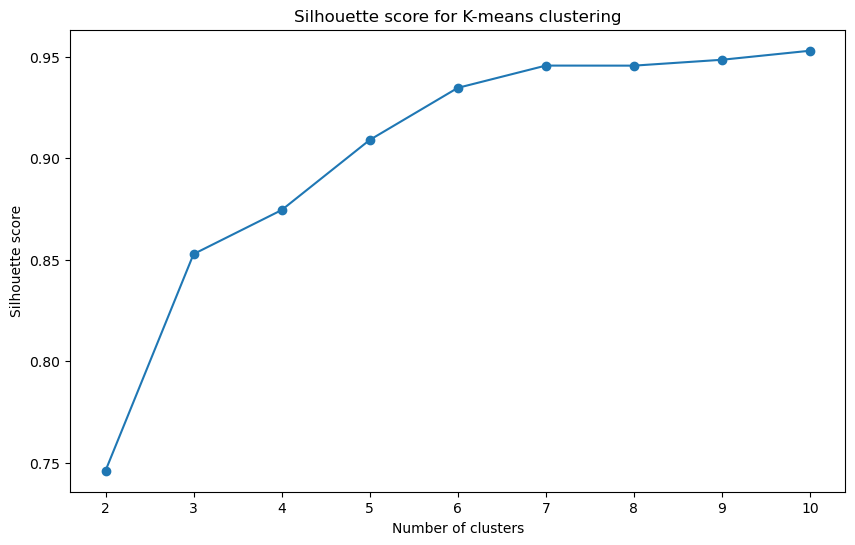

In [90]:
# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(list(kmeans_data.keys()), [x[0] for x in kmeans_data.values()], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Inertia for K-means clustering')
plt.show()

# Plot the silhouette score
plt.figure(figsize=(10, 6))
plt.plot(list(kmeans_data.keys()), [x[1] for x in kmeans_data.values()], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score for K-means clustering')

Based on the number of clusters compared to inertia and silhouette score, we can determine that 7 is the optimal number of clusters for our data with k-means clustering. We will view the clustering results at the end of this section.

### DBSCAN

Now, we will use DBSCAN to cluster our data. We will use the elbow method to determine the optimal value for epsilon that maximizes the silhouette score.

In [99]:
# DSBSCAN
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from tqdm import tqdm

epsilons = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]

# Find the best epsilon
silhouette_scores_dbscan = []
for epsilon in tqdm(epsilons):
    dbscan = DBSCAN(eps=epsilon)
    dbscan.fit(scaled_nsduh_mj)
    sil_score = silhouette_score(scaled_nsduh_mj, dbscan.labels_)
    print(f'For epsilon = {epsilon}, the silhouette score is {sil_score}')
    silhouette_scores_dbscan.append(sil_score)

  5%|▌         | 1/20 [00:47<15:08, 47.84s/it]

For epsilon = 0.1, the silhouette score is 0.7716716852807383


 10%|█         | 2/20 [01:36<14:25, 48.08s/it]

For epsilon = 0.2, the silhouette score is 0.7962269705021259


 15%|█▌        | 3/20 [02:26<13:56, 49.22s/it]

For epsilon = 0.3, the silhouette score is 0.9546958208532622


 20%|██        | 4/20 [03:17<13:14, 49.67s/it]

For epsilon = 0.4, the silhouette score is 0.9548504396515685


 25%|██▌       | 5/20 [04:06<12:25, 49.67s/it]

For epsilon = 0.5, the silhouette score is 0.9548691739593684


 30%|███       | 6/20 [04:55<11:32, 49.45s/it]

For epsilon = 0.6, the silhouette score is 0.9548920251982189


 35%|███▌      | 7/20 [05:44<10:40, 49.26s/it]

For epsilon = 0.7, the silhouette score is 0.9548920251982189


 40%|████      | 8/20 [06:32<09:47, 48.99s/it]

For epsilon = 0.8, the silhouette score is 0.9548920251982189


 45%|████▌     | 9/20 [07:21<08:58, 48.96s/it]

For epsilon = 0.9, the silhouette score is 0.9548920251982189


 50%|█████     | 10/20 [08:12<08:15, 49.50s/it]

For epsilon = 1, the silhouette score is 0.954908252031212


 55%|█████▌    | 11/20 [09:03<07:28, 49.85s/it]

For epsilon = 1.1, the silhouette score is 0.954908252031212


 60%|██████    | 12/20 [09:51<06:34, 49.37s/it]

For epsilon = 1.2, the silhouette score is 0.954908252031212


 65%|██████▌   | 13/20 [10:41<05:47, 49.64s/it]

For epsilon = 1.3, the silhouette score is 0.954908252031212


 70%|███████   | 14/20 [11:32<05:00, 50.07s/it]

For epsilon = 1.4, the silhouette score is 0.9107544687998733


 75%|███████▌  | 15/20 [12:23<04:11, 50.20s/it]

For epsilon = 1.5, the silhouette score is 0.8988744638700626


 80%|████████  | 16/20 [13:13<03:21, 50.32s/it]

For epsilon = 1.6, the silhouette score is 0.9033803610771831


 85%|████████▌ | 17/20 [14:04<02:31, 50.47s/it]

For epsilon = 1.7, the silhouette score is 0.9033803459206876


 90%|█████████ | 18/20 [14:55<01:40, 50.46s/it]

For epsilon = 1.8, the silhouette score is 0.9041820962892066


 95%|█████████▌| 19/20 [15:46<00:50, 50.66s/it]

For epsilon = 1.9, the silhouette score is 0.9085172753309191


100%|██████████| 20/20 [16:38<00:00, 49.91s/it]

For epsilon = 2, the silhouette score is 0.9085655339345029


Text(0.5, 1.0, 'Silhouette Score for DBSCAN Clustering on NSDUH Marijuana Data')

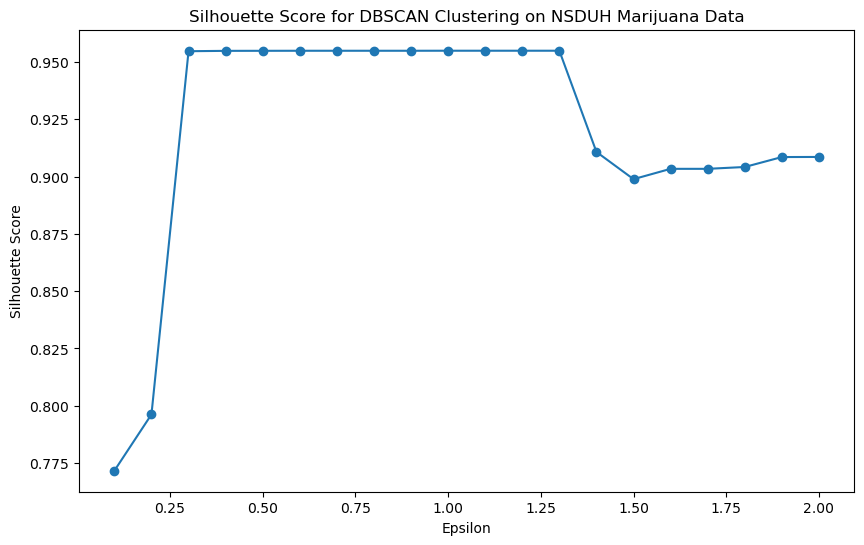

In [100]:
# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(epsilons, silhouette_scores_dbscan, marker='o')
plt.xlabel('Epsilon')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for DBSCAN Clustering on NSDUH Marijuana Data')

Based on this elbow plot, it is clear that any epsilon between 0.3 and 1.3 will give us the same clusters. I will choose 0.4 as the optimal epsilon (though any epsilon between 0.3 and 1.3 will work equally well). We get a very high silhouette score, over 0.95, meaning the separability is very good between clusters.

### Hierarchical Clustering

Finally, we will use hierarchical clustering to cluster our data. We will again use the elbow method to determine the optimal number of clusters based on silhouette score. We will use an agglomerative (bottom-up) clustering model.

In [109]:
# Hierarchical clustering
from sklearn.cluster import AgglomerativeClustering

# Find the best number of clusters
silhouette_scores = []
for num_cluster in tqdm(range(2, 11, 1)):
    agg = AgglomerativeClustering(n_clusters=num_cluster)
    agg.fit(scaled_nsduh_mj)
    silhouette_scores.append(silhouette_score(scaled_nsduh_mj, agg.labels_))

100%|██████████| 9/9 [36:59<00:00, 246.59s/it]


Text(0.5, 1.0, 'Silhouette Score for Hierarchical Clustering on NSDUH Marijuana Data')

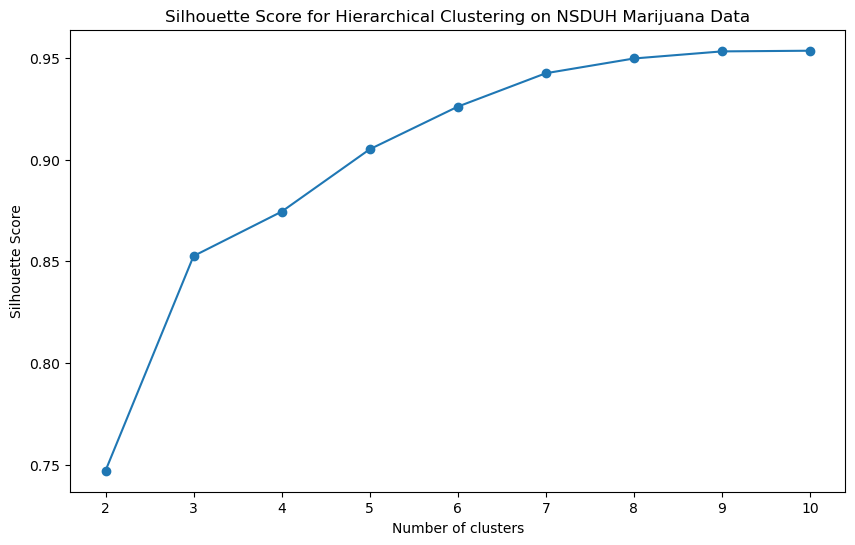

In [110]:
# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Hierarchical Clustering on NSDUH Marijuana Data')

Based on this elbow plot, we can see that 7 is the optimal number of clusters for the agglomerative clustering model with our dataset, where the silhouette score begins to level off. We will use 7 clusters for our agglomerative hierarchical clustering model.

## Results

Here, we will compare the final results from each of the three modeling approaches.

### Final Results

First, let's fit the final models with the optimal hyperparameters. Based on the analysis above, we have chose the following hyperparameters for each model:
* K-means clustering: `n_clusters` = 7
* DBSCAN: `eps` = 0.4
* Agglomerative clustering: `n_clusters` = 7

In [114]:
# Fit the optimal K-means
kmeans = KMeans(n_clusters=7, random_state=812, n_init=10, max_iter=300, init='k-means++')
kmeans.fit(scaled_nsduh_mj)
print("K-means fitted")

# Fit the optimal DBSCAN
dbscan = DBSCAN(eps=0.4)
dbscan.fit(scaled_nsduh_mj)
print("DBSCAN fitted")

# Fit the optimal hierarchical clustering
agg = AgglomerativeClustering(n_clusters=7)
agg.fit(scaled_nsduh_mj)
print("Hierarchical clustering fitted")

K-means fitted
DBSCAN fitted
Hierarchical clustering fitted


### Comparison

Now that we have fit each of the final models to the dataset, let's compare the results. First, let's look at the silhouette scores for each of the models and the chosen number of clusters.

In [115]:
print(f"""
| Model                     | Silhouette Score | Number of Clusters |
|---------------------------|------------------|--------------------|
| K-means | {silhouette_score(scaled_nsduh_mj, kmeans.labels_)} | {len(set(kmeans.labels_))} |
| DBSCAN | {silhouette_score(scaled_nsduh_mj, dbscan.labels_)} | {len(set(dbscan.labels_))} |
| Hierarchical Clustering | {silhouette_score(scaled_nsduh_mj, agg.labels_)} | {len(set(agg.labels_))} |""")


| Model                     | Silhouette Score | Number of Clusters |
|---------------------------|------------------|--------------------|
| K-means | 0.9455399987899925 | 7 |
| DBSCAN | 0.9548504396515685 | 18 |
| Hierarchical Clustering | 0.9424280327592885 | 7 |


From this table, we can see that all three of the clustering algorithms result in very high silhouette scores, all around 0.95. This indicates that the clusters are very well separated, meaning that the clustering algorithms were able to identify distinct clusters in the data. This means there are clear groups within the cannabis usage data, which we can explore further by looking at the clusters themselves.

Both the k-means model and the hierarchical clustering model resulted in 7 clusters, while the DBSCAN model resulted in 18 clusters. DBSCAN has a silhouette score of 0.955, while k-means has a score of 0.946 and hierarchical clustering has a score of 0.942. This indicates that the data is very well separated into clusters, regardless of the clustering algorithm used. Likely, this means that clusters are linearly separable. There is also a clear hierarchy in the data, as indicated by the high silhouette score for hierarchical clustering.

Let's visualize the clusters for each of the models. We will use the `smipppy` variable to color the clusters, allowing us to see how well the clusters align with the probability of severe mental illness.

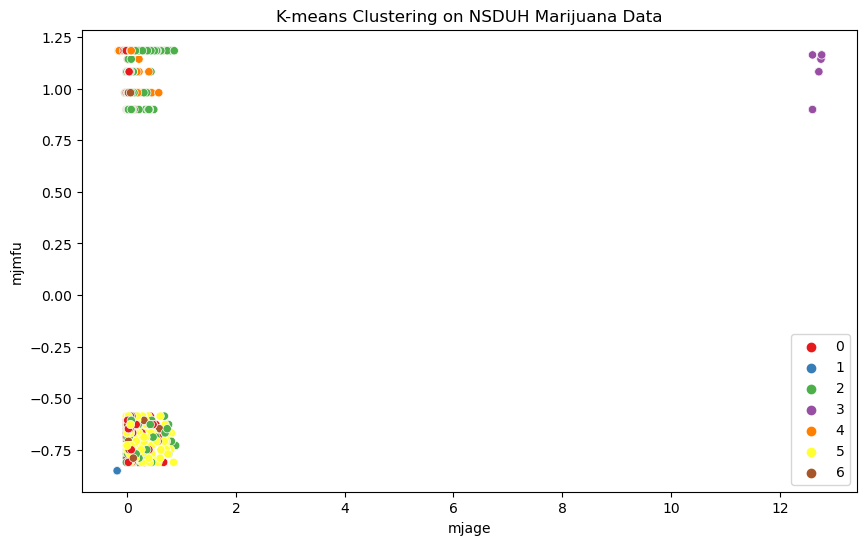

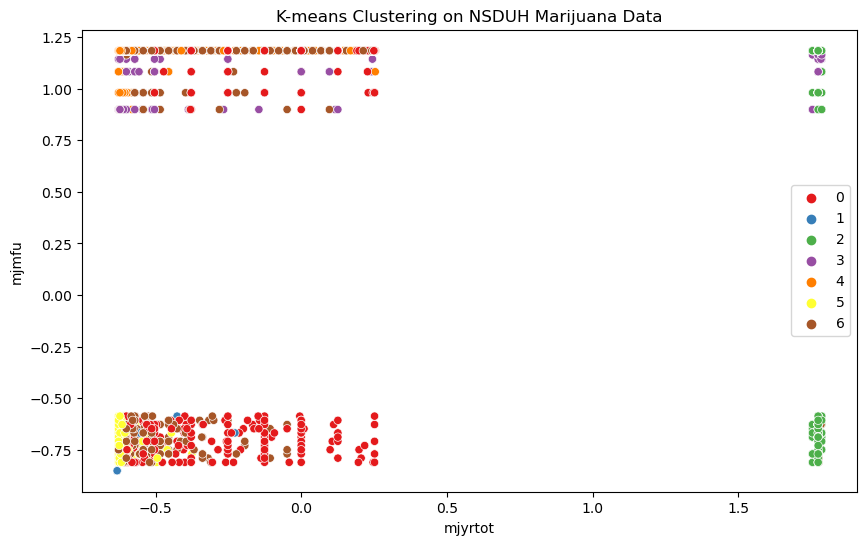

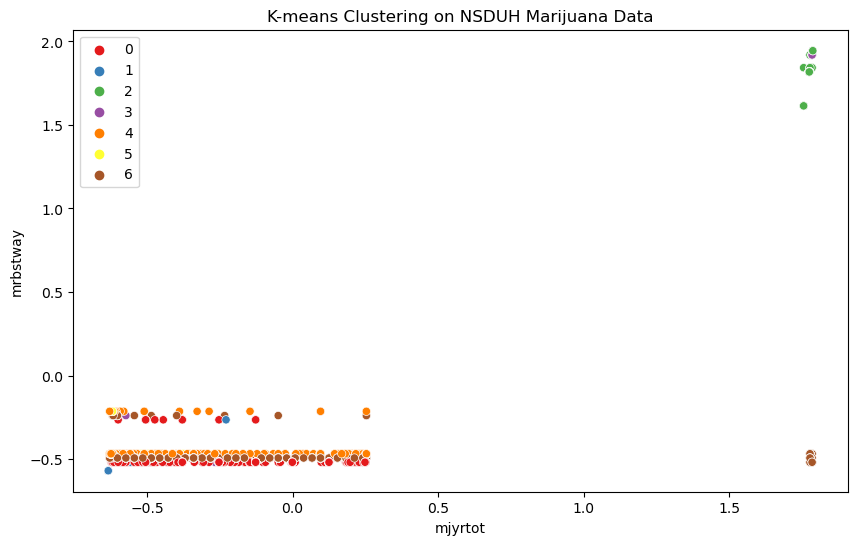

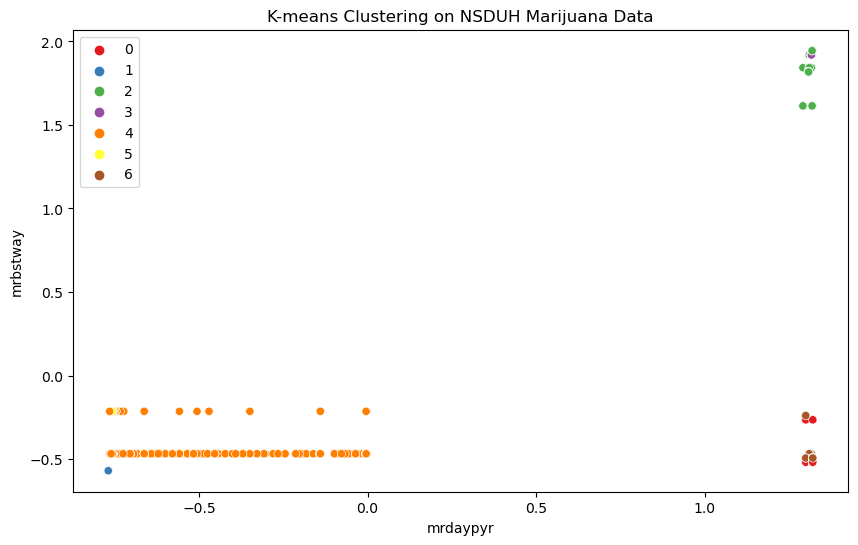

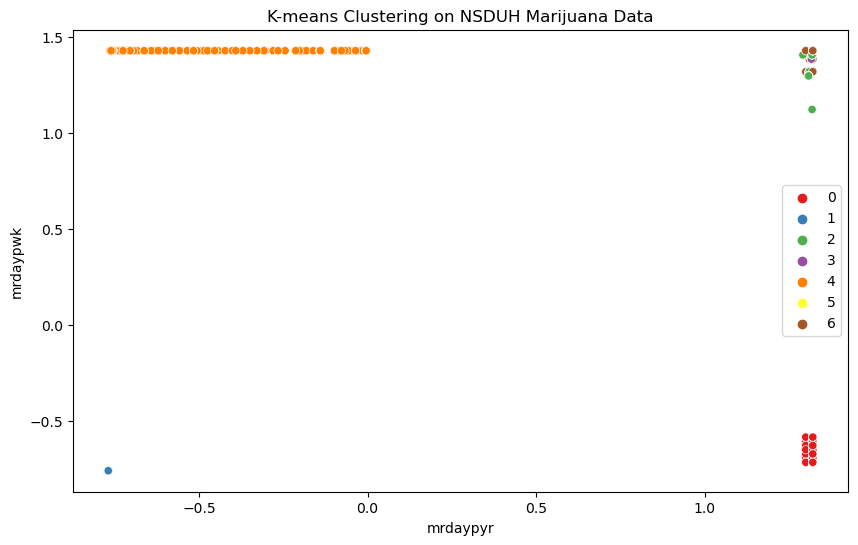

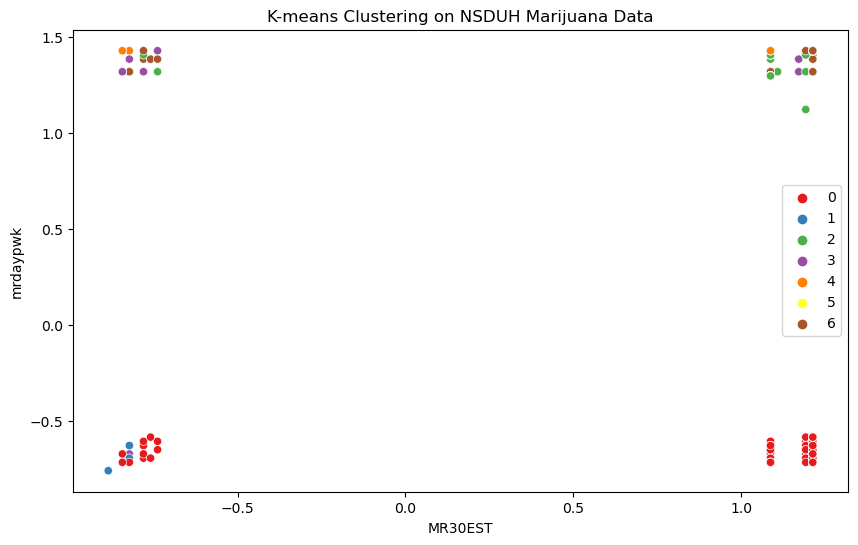

In [128]:
# Visualize the K-means clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_nsduh_mj[:, 0], y=scaled_nsduh_mj[:, 1], hue=kmeans.labels_, palette='Set1')
plt.title('K-means Clustering on NSDUH Marijuana Data')
plt.xlabel('mjage')
plt.ylabel('mjmfu')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_nsduh_mj[:, 2], y=scaled_nsduh_mj[:, 1], hue=kmeans.labels_, palette='Set1')
plt.title('K-means Clustering on NSDUH Marijuana Data')
plt.xlabel('mjyrtot')
plt.ylabel('mjmfu')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_nsduh_mj[:, 2], y=scaled_nsduh_mj[:, 3], hue=kmeans.labels_, palette='Set1')
plt.title('K-means Clustering on NSDUH Marijuana Data')
plt.xlabel('mjyrtot')
plt.ylabel('mrbstway')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_nsduh_mj[:, 4], y=scaled_nsduh_mj[:, 3], hue=kmeans.labels_, palette='Set1')
plt.title('K-means Clustering on NSDUH Marijuana Data')
plt.xlabel('mrdaypyr')
plt.ylabel('mrbstway')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_nsduh_mj[:, 4], y=scaled_nsduh_mj[:, 5], hue=kmeans.labels_, palette='Set1')
plt.title('K-means Clustering on NSDUH Marijuana Data')
plt.xlabel('mrdaypyr')
plt.ylabel('mrdaypwk')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_nsduh_mj[:, 6], y=scaled_nsduh_mj[:, 5], hue=kmeans.labels_, palette='Set1')
plt.title('K-means Clustering on NSDUH Marijuana Data')
plt.xlabel('MR30EST')
plt.ylabel('mrdaypwk')
plt.show()


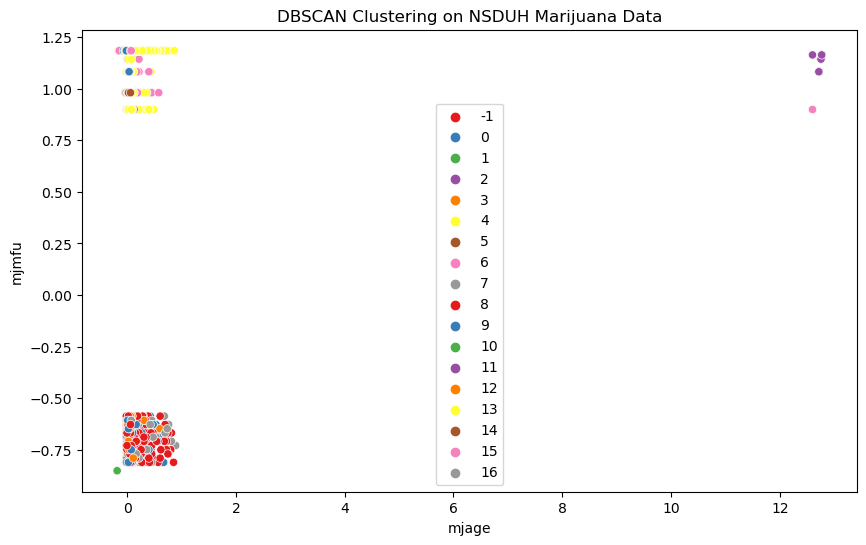

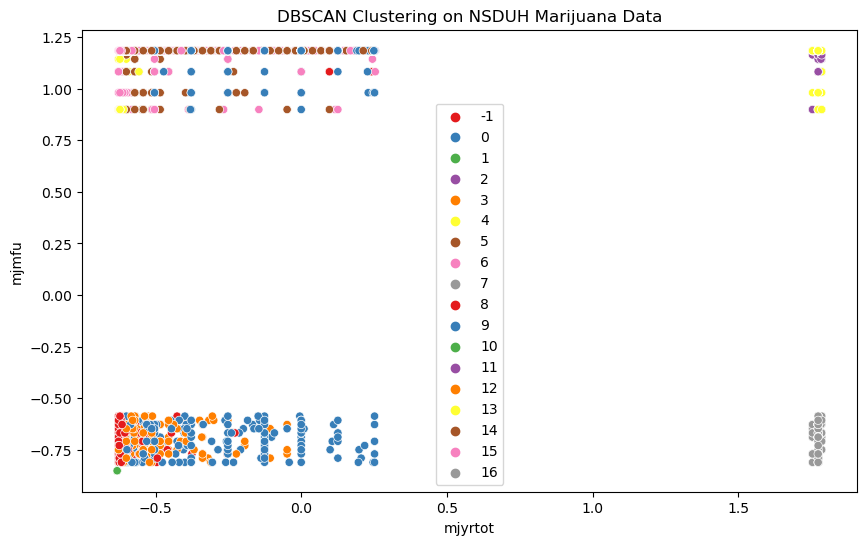

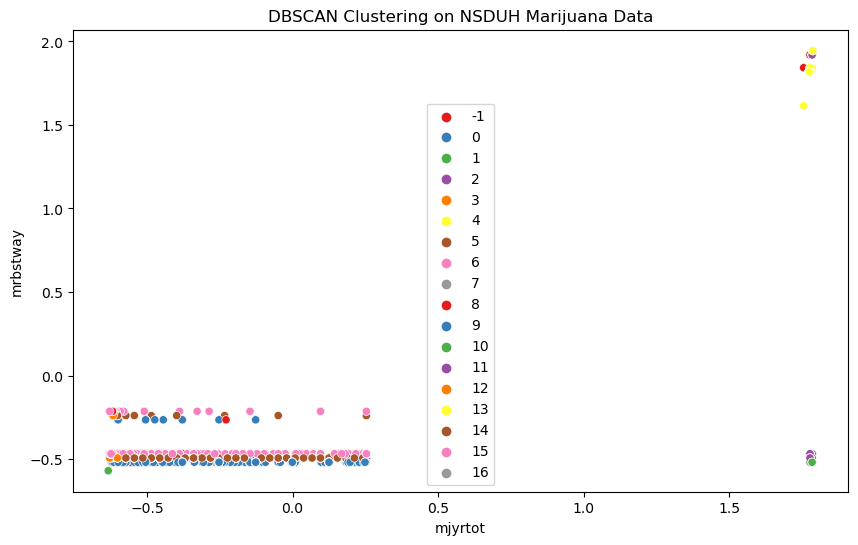

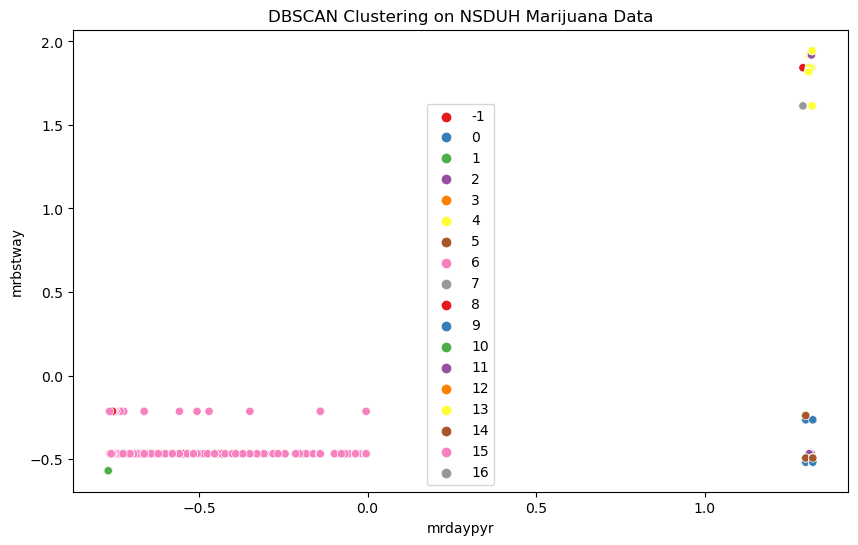

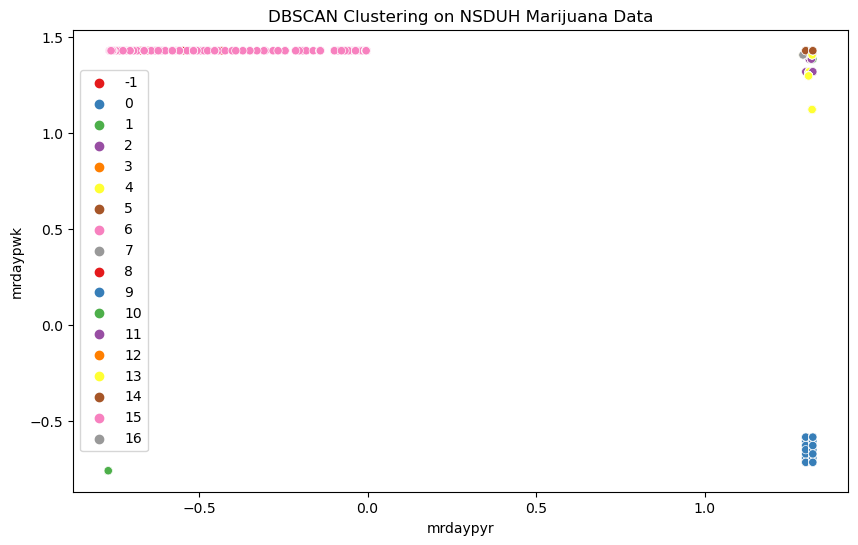

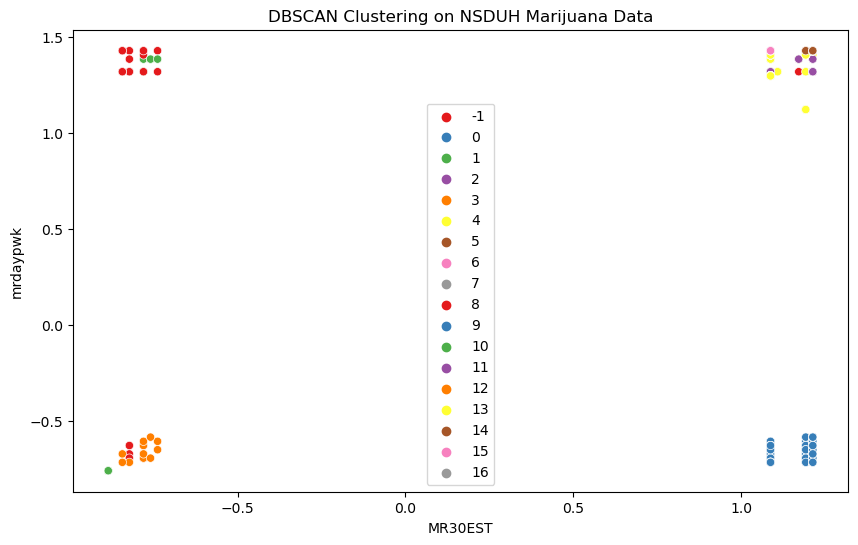

In [129]:
# Visualize the DBSCAN clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_nsduh_mj[:, 0], y=scaled_nsduh_mj[:, 1], hue=dbscan.labels_, palette='Set1')
plt.title('DBSCAN Clustering on NSDUH Marijuana Data')
plt.xlabel('mjage')
plt.ylabel('mjmfu')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_nsduh_mj[:, 2], y=scaled_nsduh_mj[:, 1], hue=dbscan.labels_, palette='Set1')
plt.title('DBSCAN Clustering on NSDUH Marijuana Data')
plt.xlabel('mjyrtot')
plt.ylabel('mjmfu')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_nsduh_mj[:, 2], y=scaled_nsduh_mj[:, 3], hue=dbscan.labels_, palette='Set1')
plt.title('DBSCAN Clustering on NSDUH Marijuana Data')
plt.xlabel('mjyrtot')
plt.ylabel('mrbstway')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_nsduh_mj[:, 4], y=scaled_nsduh_mj[:, 3], hue=dbscan.labels_, palette='Set1')
plt.title('DBSCAN Clustering on NSDUH Marijuana Data')
plt.xlabel('mrdaypyr')
plt.ylabel('mrbstway')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_nsduh_mj[:, 4], y=scaled_nsduh_mj[:, 5], hue=dbscan.labels_, palette='Set1')
plt.title('DBSCAN Clustering on NSDUH Marijuana Data')
plt.xlabel('mrdaypyr')
plt.ylabel('mrdaypwk')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_nsduh_mj[:, 6], y=scaled_nsduh_mj[:, 5], hue=dbscan.labels_, palette='Set1')
plt.title('DBSCAN Clustering on NSDUH Marijuana Data')
plt.xlabel('MR30EST')
plt.ylabel('mrdaypwk')
plt.show()


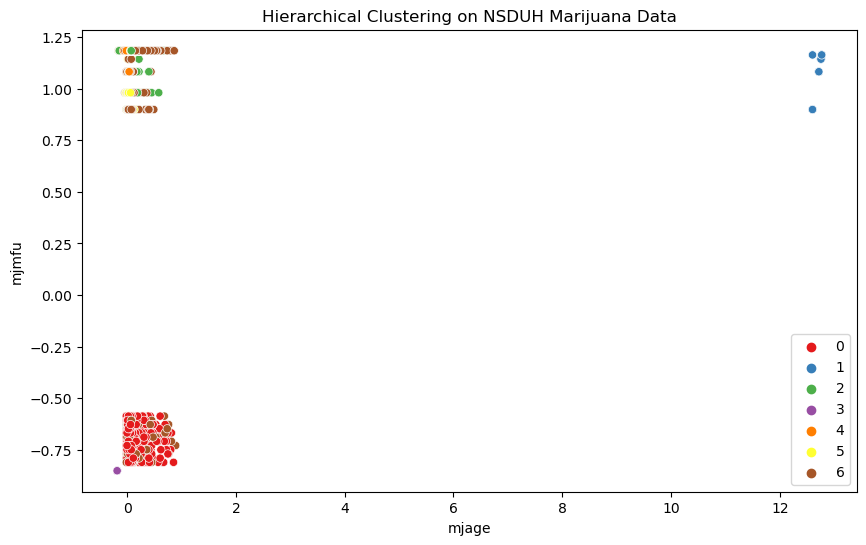

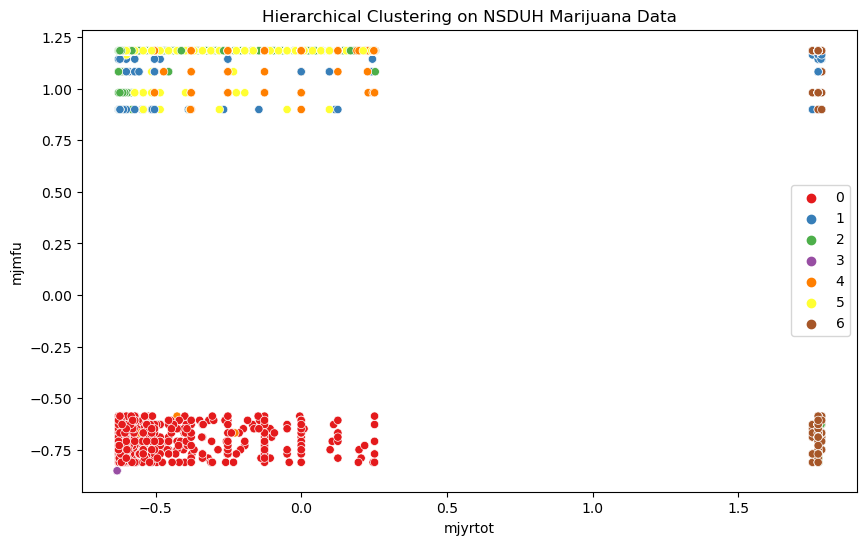

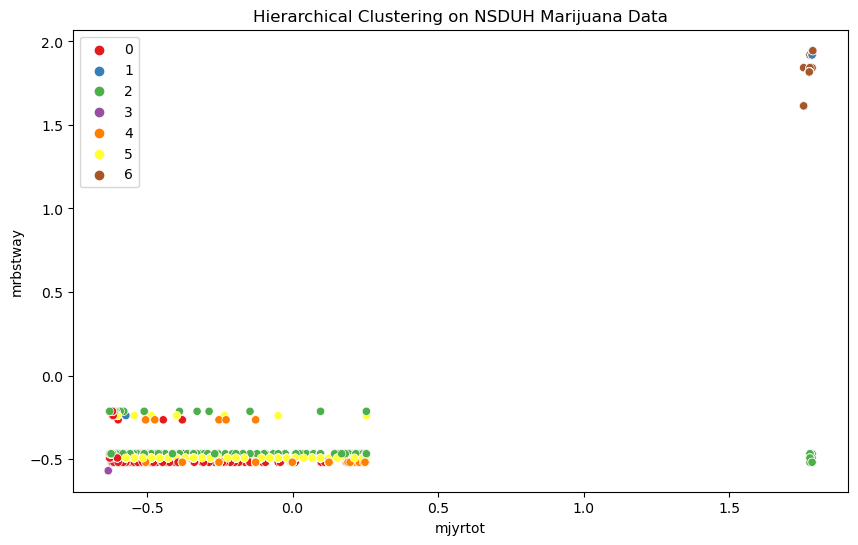

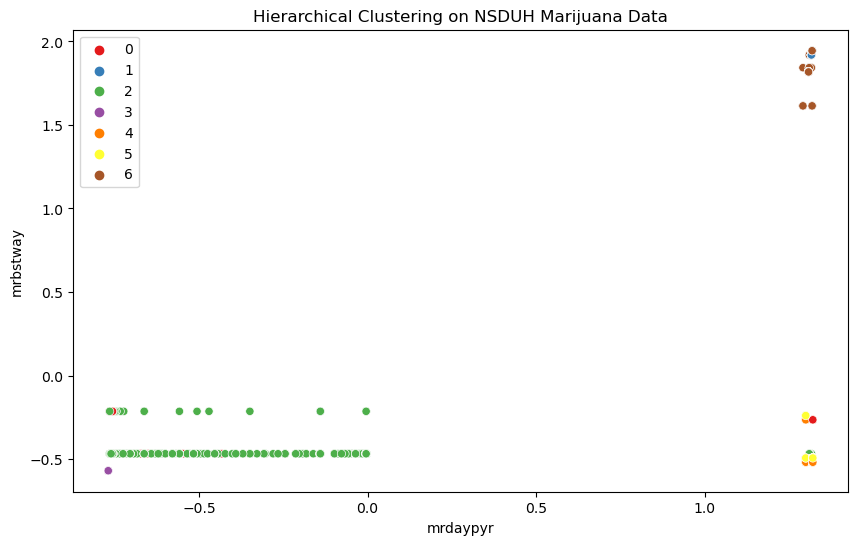

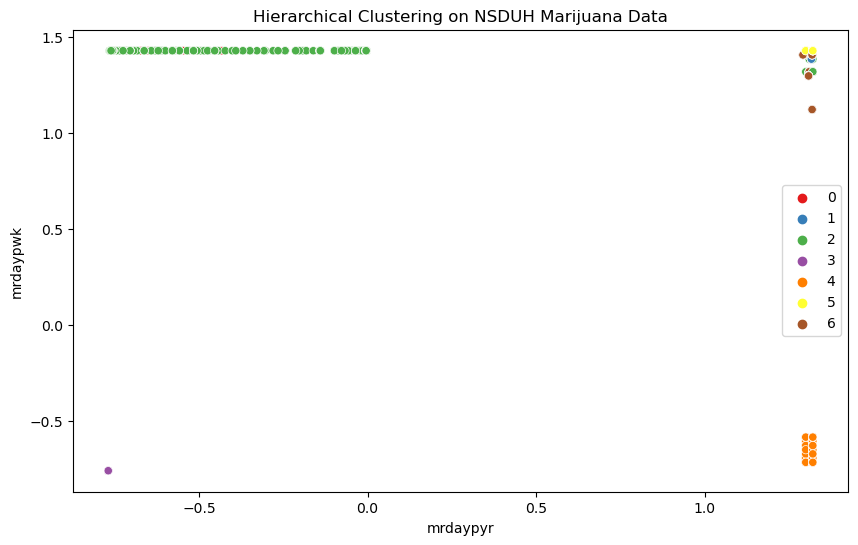

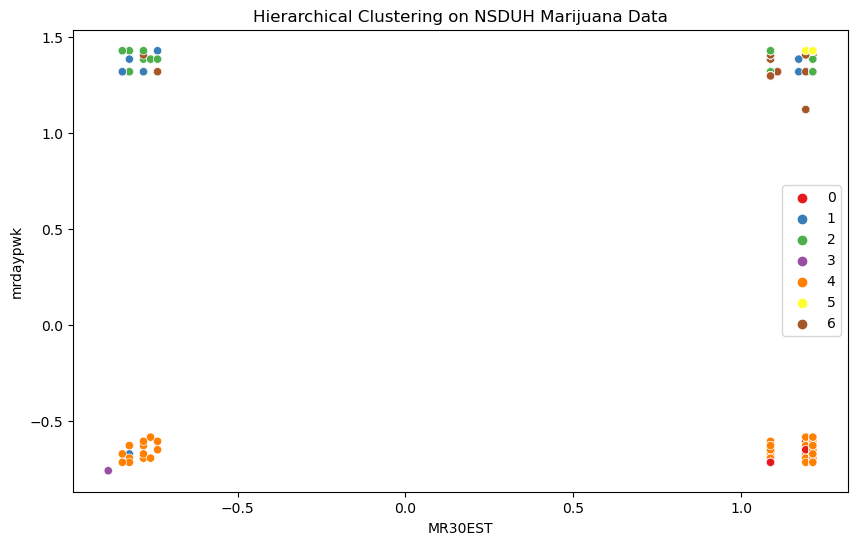

In [132]:
# Visualize the agglomerative clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_nsduh_mj[:, 0], y=scaled_nsduh_mj[:, 1], hue=agg.labels_, palette='Set1')
plt.title('Hierarchical Clustering on NSDUH Marijuana Data')
plt.xlabel('mjage')
plt.ylabel('mjmfu')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_nsduh_mj[:, 2], y=scaled_nsduh_mj[:, 1], hue=agg.labels_, palette='Set1')
plt.title('Hierarchical Clustering on NSDUH Marijuana Data')
plt.xlabel('mjyrtot')
plt.ylabel('mjmfu')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_nsduh_mj[:, 2], y=scaled_nsduh_mj[:, 3], hue=agg.labels_, palette='Set1')
plt.title('Hierarchical Clustering on NSDUH Marijuana Data')
plt.xlabel('mjyrtot')
plt.ylabel('mrbstway')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_nsduh_mj[:, 4], y=scaled_nsduh_mj[:, 3], hue=agg.labels_, palette='Set1')
plt.title('Hierarchical Clustering on NSDUH Marijuana Data')
plt.xlabel('mrdaypyr')
plt.ylabel('mrbstway')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_nsduh_mj[:, 4], y=scaled_nsduh_mj[:, 5], hue=agg.labels_, palette='Set1')
plt.title('Hierarchical Clustering on NSDUH Marijuana Data')
plt.xlabel('mrdaypyr')
plt.ylabel('mrdaypwk')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_nsduh_mj[:, 6], y=scaled_nsduh_mj[:, 5], hue=agg.labels_, palette='Set1')
plt.title('Hierarchical Clustering on NSDUH Marijuana Data')
plt.xlabel('MR30EST')
plt.ylabel('mrdaypwk')
plt.show()

In [141]:
# convert columns to numeric
nsduh_mj['mjage'] = pd.to_numeric(nsduh_mj['mjage'])
nsduh_mj['mjmfu'] = pd.to_numeric(nsduh_mj['mjmfu'])
nsduh_mj['mjyrtot'] = pd.to_numeric(nsduh_mj['mjyrtot'])
nsduh_mj['mrbstway'] = pd.to_numeric(nsduh_mj['mrbstway'])
nsduh_mj['mrdaypyr'] = pd.to_numeric(nsduh_mj['mrdaypyr'])
nsduh_mj['mrdaypwk'] = pd.to_numeric(nsduh_mj['mrdaypwk'])
nsduh_mj['MR30EST'] = pd.to_numeric(nsduh_mj['MR30EST'])

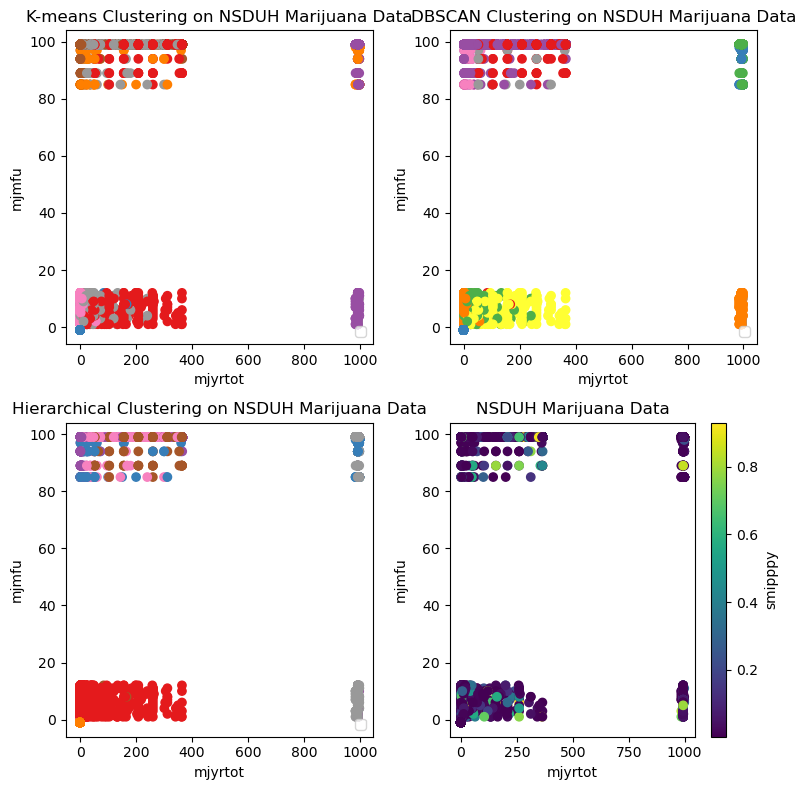

In [165]:
# Visualize the clusters with the original data
nsduh_mj['kmeans_labels'] = kmeans.labels_
nsduh_mj['dbscan_labels'] = dbscan.labels_
nsduh_mj['agg_labels'] = agg.labels_

# Visualize the clusters with the original data
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# K-means Clustering
axes[0, 0].scatter(x=nsduh_mj['mjyrtot'], y=nsduh_mj['mjmfu'], c=nsduh_mj['kmeans_labels'], cmap='Set1')
axes[0, 0].set_title('K-means Clustering on NSDUH Marijuana Data')
axes[0, 0].set_xlabel('mjyrtot')
axes[0, 0].set_ylabel('mjmfu')

# DBSCAN Clustering
axes[0, 1].scatter(x=nsduh_mj['mjyrtot'], y=nsduh_mj['mjmfu'], c=nsduh_mj['dbscan_labels'], cmap='Set1')
axes[0, 1].set_title('DBSCAN Clustering on NSDUH Marijuana Data')
axes[0, 1].set_xlabel('mjyrtot')
axes[0, 1].set_ylabel('mjmfu')

# Hierarchical Clustering
axes[1, 0].scatter(x=nsduh_mj['mjyrtot'], y=nsduh_mj['mjmfu'], c=nsduh_mj['agg_labels'], cmap='Set1')
axes[1, 0].set_title('Hierarchical Clustering on NSDUH Marijuana Data')
axes[1, 0].set_xlabel('mjyrtot')
axes[1, 0].set_ylabel('mjmfu')

# NSDUH Marijuana Data
nsduh_mj_smipppy = nsduh[['mjage', 'mjmfu', 'mjyrtot', 'mrbstway', 'mrdaypyr', 'mrdaypwk', 'MR30EST', 'smipppy']]
nsduh_mj_smipppy = nsduh_mj_smipppy.dropna()
nsduh_mj_smipppy['mjyrtot'] = nsduh_mj_smipppy['mjyrtot'].replace('Never Used', -1).astype('int')
nsduh_mj_smipppy['mjmfu'] = nsduh_mj_smipppy['mjmfu'].replace('Never Used', -1).astype('int')
axes[1, 1].scatter(x=nsduh_mj_smipppy['mjyrtot'], y=nsduh_mj_smipppy['mjmfu'], c=nsduh_mj_smipppy['smipppy'])
axes[1, 1].set_title('NSDUH Marijuana Data')
axes[1, 1].set_xlabel('mjyrtot')
axes[1, 1].set_ylabel('mjmfu')
# add colorbar
smipppy = plt.cm.ScalarMappable()
smipppy.set_array(nsduh_mj_smipppy['smipppy'])
cbar = plt.colorbar(smipppy, ax=axes[1, 1])
cbar.set_label('smipppy')

plt.tight_layout()
plt.show()

Based on these many visualizations, we can see some clear patterns among the clusters. For all 3 algorithms, there are clearly some clusters that align with individuals who have never used cannabis. Among the other clusters, the pattern is less clear. When we compare the clustering with the `smipppy` variable, we can see that there is a connection between the clusters and the probability of severe mental illness, with some of the clusters seeming to have more light colored points (indicating a higher probability of severe mental illness) than others. However, the clusters do not align very closely with the probability of severe mental illness, indicating that there is not a clear link between cannabis usage and severe mental illness. Likely, we would need to visualize more than 2 dimensions to see a clearer link between cannabis usage and severe mental illness, and there are many confounding factors than can impact the probability of severe mental illness.